# MNIST dataset

In [1]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

# Use a white background for matplotlib figures
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [2]:
from torchvision.datasets import MNIST

dataset = MNIST(root='data/', transform = ToTensor())
len(dataset)

60000

Label: 5
Label: 0
Label: 4
Label: 1


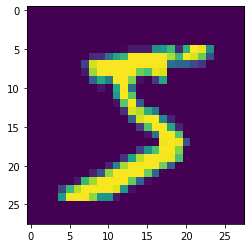

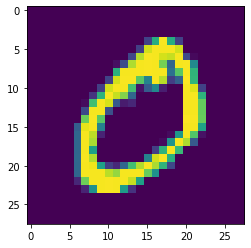

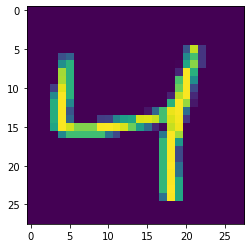

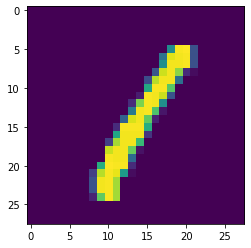

In [3]:
for i in range(len(dataset)):
    plt.figure()
    image, label = dataset[i]
    print('Label:', label)
    
    if i == 3:
        break        
    plt.imshow(image.permute(1, 2, 0))
    
plt.imshow(image.permute(1, 2, 0),)

In [4]:
from torch.utils.data import random_split

train, val = random_split(dataset, [50000, 10000])
print('len train:', len(train))
print('len val:', len(val))

len train: 50000
len val: 10000


In [5]:
batch_size = 128

train_dataloader = DataLoader(train, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dataloader = DataLoader(val, batch_size*2, num_workers=4, pin_memory=True)

torch.Size([128, 1, 28, 28])


[]

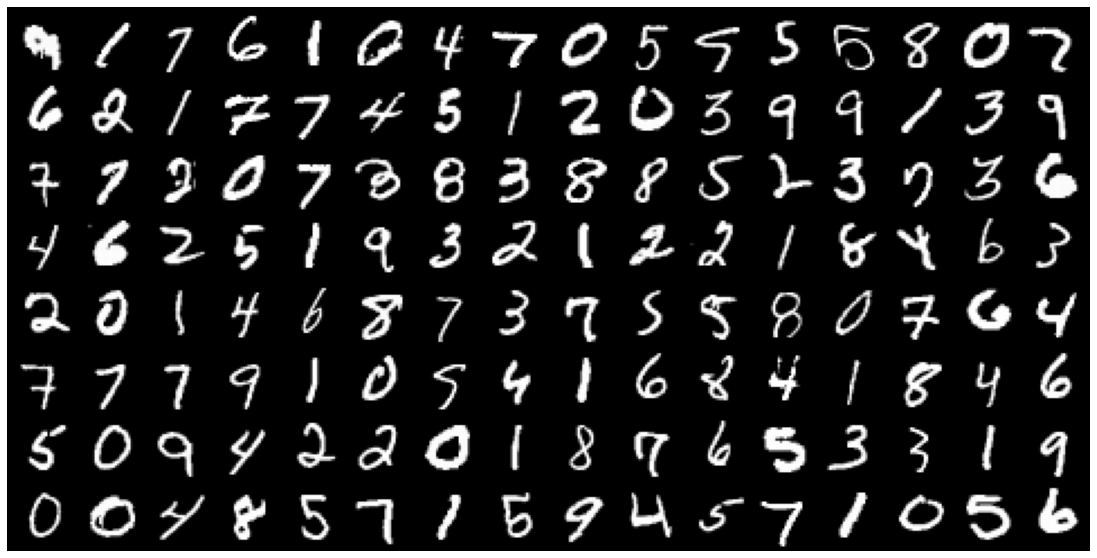

In [6]:
# Just first batch
for images, _ in train_dataloader:
    print(images.shape)
    plt.figure(figsize=(20, 10))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

plt.plot()

In [7]:
for images, label in train_dataloader:
    print('imgs shape:', images.shape)
    # input flattened
    inputs = images.reshape(-1, 784)
    print('inputs shape: ', inputs.shape)
    break

imgs shape: torch.Size([128, 1, 28, 28])
inputs shape:  torch.Size([128, 784])


In [8]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [9]:
class MNIST_model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()       
        # Layer 1 
        self.linear1 = nn.Linear(input_size, hidden_size)
        # 
        self.linear2 = nn.Linear(hidden_size, 32)
        # Layer 2
        self.linear3 = nn.Linear(32, output_size)
        
    def forward(self, x):
        # Flatten the x
        x = x.view(x.size(0), -1)
        # Output from layer1
        output = self.linear1(x)
        # Output from ReLU
        output = F.relu(output)
        # Output from layer2
        output = self.linear2(output)
        
        output = F.relu(output)
        
        output = self.linear3(output)
        
        return output
        
    def training_step(self, batch):
        images, labels = batch # Get data
        outputs = self(images)  #Prediction
        loss = F.cross_entropy(outputs, labels) #Calculate loss

        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        outputs = self(images)                    
        loss = F.cross_entropy(outputs, labels)   
        acc = accuracy(outputs, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
    
    def validation_epoch_end(self, outputs):
        batch_loss = [output['val_loss'] for output in outputs]
        battch_acc = [output['val_acc'] for output in outputs]
        
        ep_loss = torch.stack(batch_loss).mean()
        ep_acc = torch.stack(battch_acc).mean()
        
        return {'val_loss': ep_loss.item(), 'val_acc': ep_acc.item()}
        
    
    def result_ep_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [10]:
input_size = 784
hidden_size = 64
num_classes = 10

In [11]:
model = MNIST_model(input_size, hidden_size, num_classes)
model

MNIST_model(
  (linear1): Linear(in_features=784, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=32, bias=True)
  (linear3): Linear(in_features=32, out_features=10, bias=True)
)

# GPU

In [12]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
device = get_default_device()

In [13]:
'''Finally, we define a DeviceDataLoader class to wrap our existing data loaders and move batches of data to the selected
device. Interestingly, we don't need to extend an existing class to create a PyTorch datal oader. All we need is an
__iter__ method to retrieve batches of data and an __len__ method to get the number of batches.
'''
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [14]:
train_dataloader = DeviceDataLoader(train_dataloader, device)
val_dataloader = DeviceDataLoader(val_dataloader, device)

In [15]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [16]:
def evaluate(model, val_dataloader):
    """Evaluate the model's performance on the validation set"""
    outputs = [model.validation_step(batch) for batch in val_dataloader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func):
    """Train the model using gradient descent"""
    history = []
    optimizer = opt_func(model.parameters(), lr)
    
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # Validation phase
        result = evaluate(model, val_loader)
        model.result_ep_end(epoch, result)
        
        history.append(result)
        
    return history

In [17]:
# Model (on GPU)
model = MNIST_model(input_size, hidden_size=hidden_size, output_size=num_classes)
to_device(model, device)

MNIST_model(
  (linear1): Linear(in_features=784, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=32, bias=True)
  (linear3): Linear(in_features=32, out_features=10, bias=True)
)

In [18]:
# Untrained
history = [evaluate(model, val_dataloader)]
history

[{'val_loss': 2.3078269958496094, 'val_acc': 0.12041015923023224}]

In [19]:
history_sgd = fit(10, 0.1, model, train_dataloader, val_dataloader, opt_func = torch.optim.SGD)
torch.cuda.empty_cache()

Epoch [0], val_loss: 0.3679, val_acc: 0.8964
Epoch [1], val_loss: 0.2761, val_acc: 0.9231
Epoch [2], val_loss: 0.2339, val_acc: 0.9326
Epoch [3], val_loss: 0.2002, val_acc: 0.9439
Epoch [4], val_loss: 0.1783, val_acc: 0.9488
Epoch [5], val_loss: 0.1605, val_acc: 0.9538
Epoch [6], val_loss: 0.1466, val_acc: 0.9586
Epoch [7], val_loss: 0.1381, val_acc: 0.9610
Epoch [8], val_loss: 0.1353, val_acc: 0.9611
Epoch [9], val_loss: 0.1253, val_acc: 0.9630


In [21]:
history_adam = fit(10, 0.1, model, train_dataloader, val_dataloader, opt_func = torch.optim.Adam)
torch.cuda.empty_cache()

Epoch [0], val_loss: 0.8419, val_acc: 0.7529
Epoch [1], val_loss: 0.6786, val_acc: 0.8161
Epoch [2], val_loss: 0.7700, val_acc: 0.8145
Epoch [3], val_loss: 0.6730, val_acc: 0.8101
Epoch [4], val_loss: 0.8867, val_acc: 0.7768
Epoch [5], val_loss: 1.0179, val_acc: 0.6507
Epoch [6], val_loss: 0.8201, val_acc: 0.7948
Epoch [7], val_loss: 0.7560, val_acc: 0.7935
Epoch [8], val_loss: 0.7811, val_acc: 0.7927
Epoch [9], val_loss: 0.8991, val_acc: 0.6976


In [22]:
history_adamw = fit(10, 0.1, model, train_dataloader, val_dataloader, opt_func = torch.optim.AdamW)
torch.cuda.empty_cache()

Epoch [0], val_loss: 0.8626, val_acc: 0.7534
Epoch [1], val_loss: 0.8036, val_acc: 0.7875
Epoch [2], val_loss: 0.8367, val_acc: 0.7574
Epoch [3], val_loss: 0.8051, val_acc: 0.7704
Epoch [4], val_loss: 0.7663, val_acc: 0.7799
Epoch [5], val_loss: 1.3340, val_acc: 0.6881
Epoch [6], val_loss: 0.9886, val_acc: 0.7307
Epoch [7], val_loss: 0.7518, val_acc: 0.7811
Epoch [8], val_loss: 0.8700, val_acc: 0.7413
Epoch [9], val_loss: 0.7884, val_acc: 0.7797


Text(0.5, 1.0, 'Accuracy vs. No. of epochs')

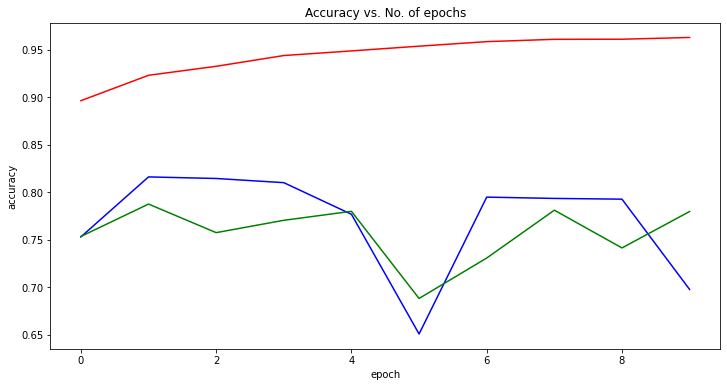

In [23]:
acc_sgd = [result['val_acc'] for result in history_sgd]
acc_adamw = [result['val_acc'] for result in history_adamw]
acc_adam = [result['val_acc'] for result in history_adam]

plt.figure(figsize=(12,6))

plt.plot(acc_sgd, 'r')
plt.plot(acc_adam, 'b')
plt.plot(acc_adamw, 'g')


plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs')